In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip3 install easydict
!pip3 install pycocotools

  Preparing metadata (setup.py) ... done
  Created wheel for easydict: filename=easydict-1.10-py3-none-any.whl size=5926 sha256=fce3551fde01f597d4156b31b39e83dc07fac0a51967d14e73e760c9fa5b24a6
  Stored in directory: /root/.cache/pip/wheels/67/5f/3d/153c230df93efb11f7f66b162e844294d332ce939eb92fe6c6
Successfully built easydict
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp36-cp36m-linux_x86_64.whl size=267687 sha256=e1cb6f16ada1ed55abc6ed29e60c0c1c9ccd9cc85f99467fd122e1f80639a07f
  Stored in directory: /root/.cache/pip/wheels/39/5f/a6/d19eb746e1b7525795fa8910576ddc6108d0c9cf343e4155e8
Successfully built pycocotools


loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


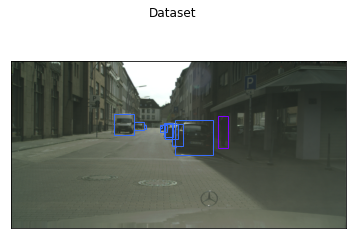

In [3]:
import os
import sys
import easydict

import torchvision
import matplotlib.pyplot as plt

from dataset.utils import build_dataset
from utils import visualize_bbox_cxcy

WORK_DIR = '/ws/external'
if WORK_DIR not in sys.path:
    sys.path.append(WORK_DIR)
from dataset.utils import build_dataset
from utils import visualize_bbox_cxcy
    
###############
### Setting ###
###############
config = easydict.EasyDict({
    'dataset': {
        'root_dir': '/ws/data/cityscapes/leftImg8bit',
        'ann_file': '/ws/data/cityscapes/annotations/instancesonly_filtered_gtFine_train.json',
        'transforms': [torchvision.transforms.ToTensor()],
    },
    'device': 'cuda',
})

###############
### Dataset ###
###############
dataset = build_dataset(config.dataset)

#################
### Visualize ###
#################
image = dataset[0]['image']
labels = dataset[0]['labels']
bboxes = dataset[0]['bboxes']

fig, ax = plt.subplots(1,1)
ax.imshow(image.permute(1,2,0).numpy())
for i in range(len(bboxes)):
    fig, ax = visualize_bbox_cxcy(bboxes[i],
                                  fig, ax,
                                  num_colors=dataset.num_classes,
                                  color_idx=int(labels[i]))
ax.axes.set_xticks([])
ax.axes.set_yticks([])
fig.suptitle('Dataset')
plt.show(fig)

# Backbone

Extracts features from image

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%


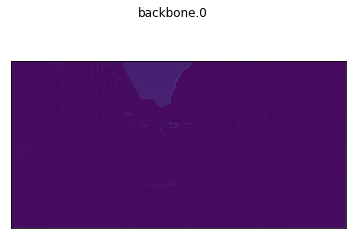

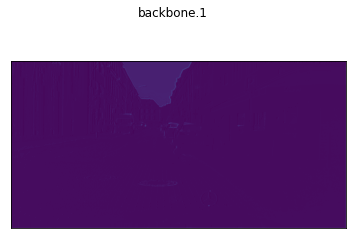

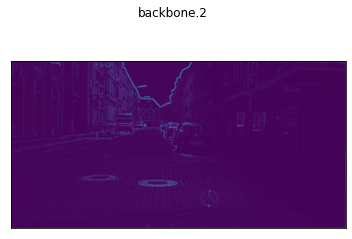

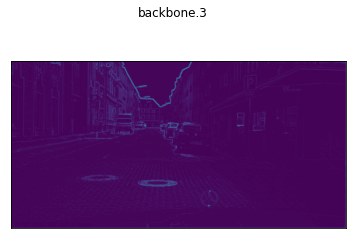

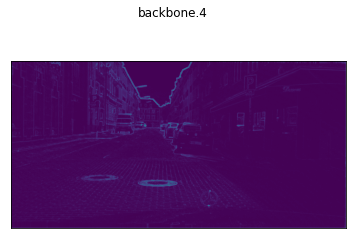

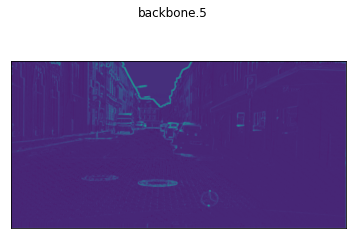

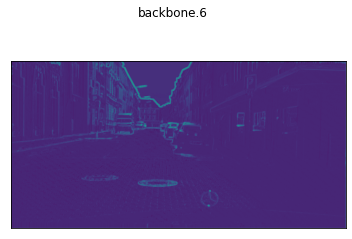

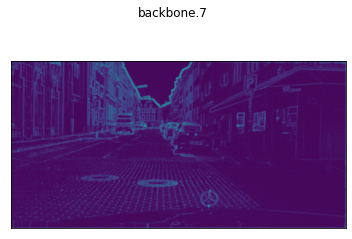

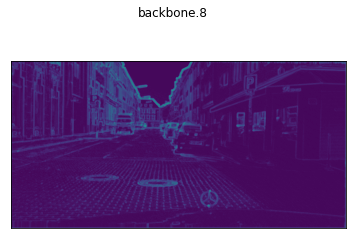

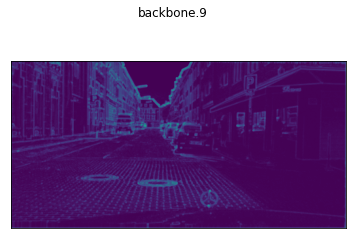

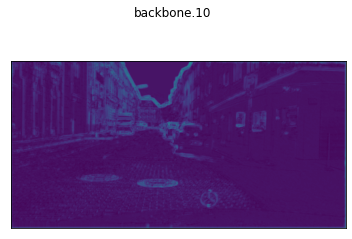

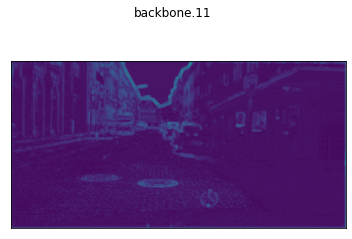

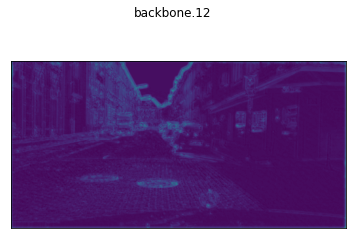

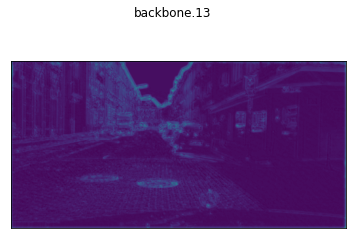

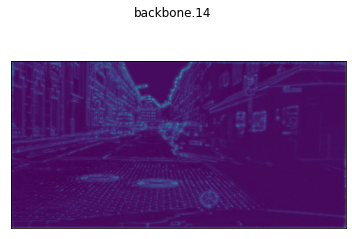

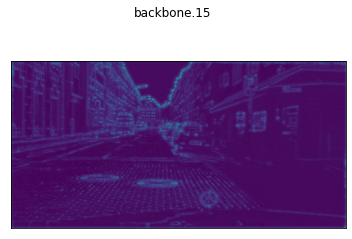

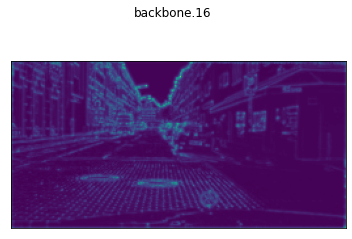

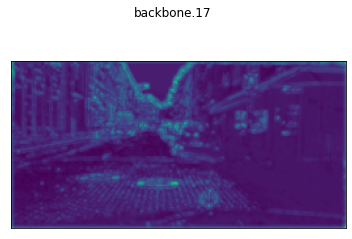

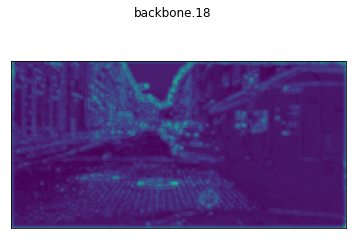

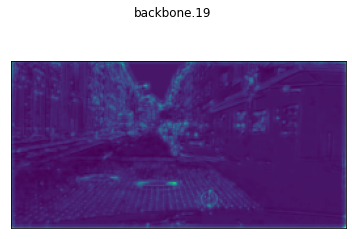

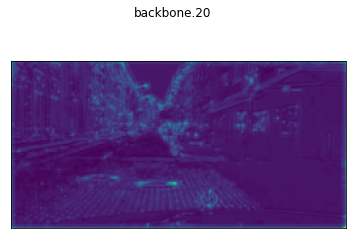

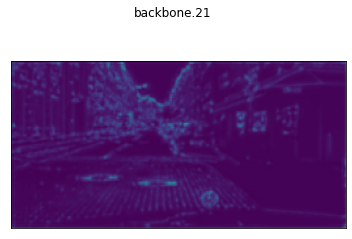

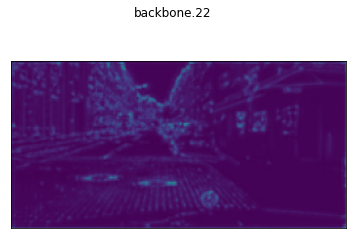

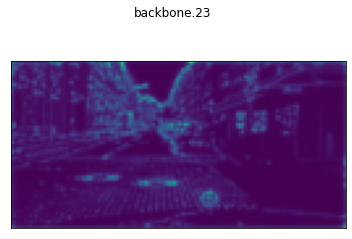

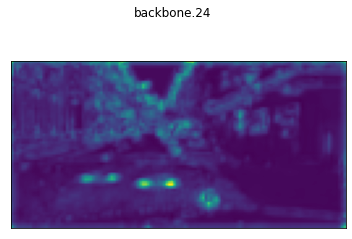

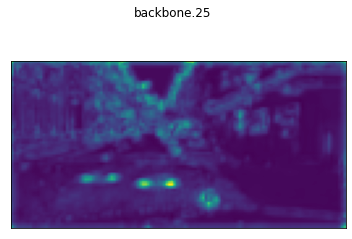

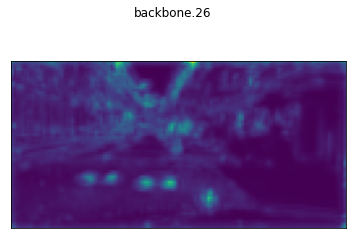

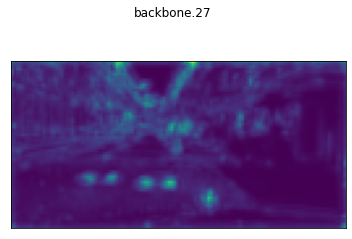

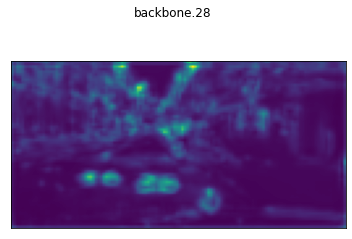

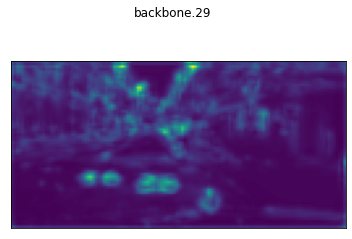

In [4]:
from model.backbone import build_backbone

###############
### Setting ###
###############
config['model'] = {
    'backbone': {
        'type': 'vgg16',
    },
}

################
### Backbone ###
################
backbone = build_backbone(config.model.backbone)

#################
### Visualize ###
#################
import easydict
from dataset.utils import build_dataset
from dscv.utils.param_manager import ParamManager
from utils import visualize_feature_summary


backbone = build_backbone(config.model.backbone).to(config.device)

# Hook
param_manager = ParamManager()
# param_manager.check_param_structure(backbone)
layer_name_list = [str(i) for i in range(30)]
param_manager.register_forward_hook(backbone, layer_name_list, type='output')

# Forward
features = backbone(image.unsqueeze(0).to(config.device))

# Visualize
for i in range(30):
    fig, ax = plt.subplots(1, 1)
    feature = param_manager.hook_results['output'][str(i)]
    visualize_feature_summary(feature.squeeze(0), fig, ax)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    fig.suptitle(f'backbone.{i}')
    plt.show(fig)
param_manager.hook_results['output'] = {}


# RPN

In [5]:
###############
### Setting ###
###############
config['model'].update({
    'rpn': {
        'image_shape': [1024, 2048],
        'in_channels': 512,
        'feat_channels': 512,
        'anchor': {
            'base_size': 16,
            'ratios': [0.5, 1.0, 2.0],
            'scales': [8, 16, 32],
        },
        'nms_pre': 2000,
    },
})

**Anchor**
1. Generate `anchor_base` : 

    generates boxes with each scale and each ratio. If scale=[8, 16, 32] and ratios=[0.5, 1.0, 2.0], then 2:1, 1:1, 1:2 boxes are generated with 8, 16, and 32 scale
    
    
2. Generate `anchors` : 

    Generates anchors as much as image size. If image shape is (3, H, W) and the `base_size` is 16, then the anchors are generated as much as (H/`base_size`)*(W/`base_size`).
   


Generate anchor base... 
  Output: 
  > anchor_base : torch.Size([9, 4])
tensor([[ -37.2548,  -82.5097,   53.2548,   98.5097],
        [ -82.5097, -173.0193,   98.5097,  189.0193],
        [-173.0193, -354.0387,  189.0193,  370.0387],
        [ -56.0000,  -56.0000,   72.0000,   72.0000],
        [-120.0000, -120.0000,  136.0000,  136.0000],
        [-248.0000, -248.0000,  264.0000,  264.0000],
        [ -82.5097,  -37.2548,   98.5097,   53.2548],
        [-173.0193,  -82.5097,  189.0193,   98.5097],
        [-354.0387, -173.0193,  370.0387,  189.0193]])


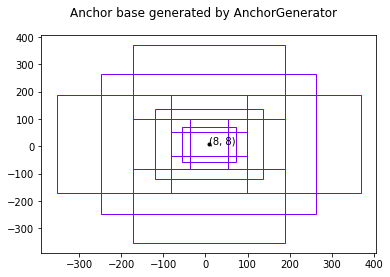

In [6]:
from model.rpn import build_anchor_generator

########################
### Anchor Generator ###
########################
anchor_generator = build_anchor_generator(config.model.rpn.anchor)

##############################
### Visualize: anchor base ###
##############################
from utils import visualize_bboxes_xy

anchor_base = anchor_generator.anchor_base
print(f"Generate anchor base... ")
print(f"  Output: ")
print(f"  > anchor_base : {anchor_base.shape}")
print(anchor_base)

fig, ax = visualize_bboxes_xy(anchor_base)
ax.plot([anchor_generator.base_size/2], [anchor_generator.base_size/2], '.', color='black')
ax.annotate(f'({int(anchor_generator.base_size/2)}, {int(anchor_generator.base_size/2)})',
            (anchor_generator.base_size/2, anchor_generator.base_size/2))
fig.suptitle('Anchor base generated by AnchorGenerator')
plt.show(fig)

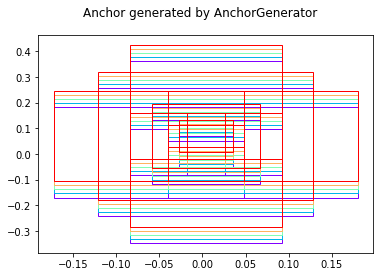

In [7]:
from model.rpn import build_anchor_generator

#########################################
### Anchor Generator: Generate anchor ###
#########################################
anchor = anchor_generator.generate_anchor(config.model.rpn.image_shape)

#########################
### Visualize: anchor ###
#########################
fig, ax = plt.subplots(1,1)
num_vis = 5
for i in range(num_vis):
    fig, ax = visualize_bboxes_xy(anchor[9*i: 9*(i+1),:],
                                  fig=fig, ax=ax, 
                                  color_idx=i, num_colors=num_vis)
fig.suptitle('Anchor generated by AnchorGenerator')
plt.show(fig)

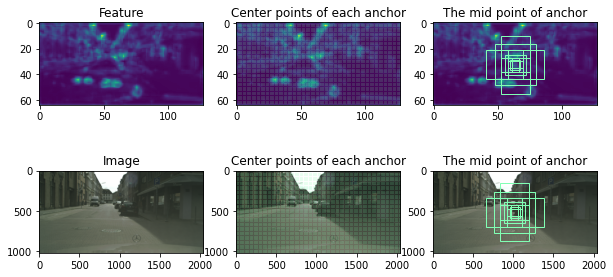

In [9]:
#########################
### Visualize: anchor ###
#########################
anchor = anchor_generator.generate_anchor(config.model.rpn.image_shape)

import torch
from utils import visualize_feature_summary, get_color_array
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

# axes[0,0]: Feature
ax = axes[0,0]
visualize_feature_summary(features[0], fig=fig, ax=ax)
ax.axes.set_title('Feature')

# axes[0,1]: Center points of each anchor
ax = axes[0,1]
visualize_feature_summary(features[0], fig=fig, ax=ax)

COLOR_ARRAY = get_color_array(num_colors=3)
feat_width, feat_height = features.shape[-1], features.shape[-2]
ids = torch.arange(0, feat_width*feat_height*9, 9)
cx = ((anchor[ids][:,2]+anchor[ids][:,0])/2. * feat_width).cpu().detach().numpy()
cy = ((anchor[ids][:,3]+anchor[ids][:,1])/2. * feat_height).cpu().detach().numpy()
ax.plot(cx, cy, '.', color=COLOR_ARRAY[1], markersize=0.1)
ax.axes.set_title('Center points of each anchor')

# axes[0,2]: The mid point of anchor
ax = axes[0,2]
visualize_feature_summary(features[0], fig=fig, ax=ax)

scale = torch.tensor([feat_width, feat_height, feat_width, feat_height])
mid_idx = int(9*feat_height*(feat_width/2 - 1) + (9*feat_height/2))
visualize_bboxes_xy(anchor[mid_idx:mid_idx+9] * scale, ax=ax, color=COLOR_ARRAY[1])
ax.axes.set_title('The mid point of anchor')

# axes[1,0]: Image
ax = axes[1,0]
ax.imshow(image.permute(1,2,0).cpu().detach().numpy())
ax.axes.set_title('Image')

# axes[0,1]: Center points of each anchor
ax = axes[1,1]
ax.imshow(image.permute(1,2,0).cpu().detach().numpy())

image_width, image_height = image.shape[-1], image.shape[-2]
ids = torch.arange(0, feat_width*feat_height*9, 9)
cx = ((anchor[ids][:,2]+anchor[ids][:,0])/2. * image_width).cpu().detach().numpy()
cy = ((anchor[ids][:,3]+anchor[ids][:,1])/2. * image_height).cpu().detach().numpy()
ax.plot(cx, cy, '.', color=COLOR_ARRAY[1], markersize=0.1)
ax.axes.set_title('Center points of each anchor')

# axes[0,2]: The mid point of anchor
ax = axes[1,2]
ax.imshow(image.permute(1,2,0).cpu().detach().numpy())

scale = torch.tensor([image_width, image_height, image_width, image_height])
visualize_bboxes_xy(anchor[mid_idx:mid_idx+9] * scale, ax=ax, color=COLOR_ARRAY[1])
ax.axes.set_title('The mid point of anchor')

plt.show(fig)

**RegionProposalNetwork**

1. RPN forward :

    The features from backbone are entered into rpn. Then `rpn_cls_score` and `rpn_bbox_pred` are outputed from rpn.
    
    
2. RPN Proposal :
    
    1. `rpn_cls_scores` →[reshape&sigmoid]→ `cls_scores`
    2. `rpn_bbox_preds` →[reshape]→ `bbox_preds`
    3. `anchors` →[xy2cxcy]→ `center_anchors`
    4. Decode: 
        1. sort `cls_scores`, `bbox_preds`, `center_anchors` according to scores
        2. pick top-`nms_pre`
    

In [10]:
from model.rpn import build_rpn

#############################
### RegionProposalNetwork ###
#############################
rpn = build_rpn(config.model.rpn).to(config.device)
rois, cls_scores, bbox_preds = rpn(features)

##############################
### Print: Forward process ###
##############################
print(f"*** Forward process ***")
print(f"Input: ")
print(f"  > features: {features.shape}")
print(f"Network: ")
print(f"  > {rpn.rpn_conv}")
print(f"  > F.relu()")
print(f"  > {rpn.rpn_cls}")
print(f"  > {rpn.rpn_reg}")

import torch.nn.functional as F
out = F.relu(rpn.rpn_conv(features), inplace=True)
rpn_cls_scores = rpn.rpn_cls(out)
rpn_bbox_preds = rpn.rpn_reg(out)
print(f"Output:")
print(f"  > rpn_cls_scores: {rpn_cls_scores.shape}")
print(f"  > rpn_bbox_preds: {rpn_bbox_preds.shape}", end='\n\n')


*** Forward process ***
Input: 
  > features: torch.Size([1, 512, 64, 128])
Network: 
  > Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  > F.relu()
  > Conv2d(512, 9, kernel_size=(1, 1), stride=(1, 1))
  > Conv2d(512, 36, kernel_size=(1, 1), stride=(1, 1))
Output:
  > rpn_cls_scores: torch.Size([1, 9, 64, 128])
  > rpn_bbox_preds: torch.Size([1, 36, 64, 128])



In [11]:
####################
### RPN Proposal ###
####################
output = rpn.rpn_proposal(
    rpn_cls_scores, 
    rpn_bbox_preds)
rois = output['rois']
cls_scores = output['cls_scores']
bbox_preds = output['bbox_preds']

###################################
### Print: RPN proposal process ###
###################################
print(f"*** RPN Proposal ***")
print(f"Input: ")
print(f"  > rpn_cls_scores: {rpn_cls_scores.shape}")
print(f"  > rpn_bbox_preds: {rpn_bbox_preds.shape}")
print(f"Process: ")
batch_size = rpn_cls_scores.shape[0]
cls_scores = torch.sigmoid(rpn_cls_scores.permute(0, 2, 3, 1).contiguous().reshape(batch_size, -1))
print(f"  1. Calculate class score")
print(f"    > cls_scores: {cls_scores.shape}")
bbox_preds = rpn_bbox_preds.permute(0, 2, 3, 1).contiguous().reshape(batch_size, -1, 4)
print(f"  2. Get bounding box")
print(f"    > bbox_preds: {bbox_preds.shape}")
center_anchors = rpn._xy2cxcy(anchor).to(bbox_preds.get_device())
print(f"  3. Make anchors from cxcy to xy form")
print(f"    > center_anchors: {center_anchors.shape}")
print(f"  4. Decode: pick top-nme_pre")
print(f"    > rois: {rois.shape}")
print(f"    > cls_scores: {cls_scores.shape}")
print(f"    > bbox_preds: {bbox_preds.shape}")


*** RPN Proposal ***
Input: 
  > rpn_cls_scores: torch.Size([1, 9, 64, 128])
  > rpn_bbox_preds: torch.Size([1, 36, 64, 128])
Process: 
  1. Calculate class score
    > cls_scores: torch.Size([1, 73728])
  2. Get bounding box
    > bbox_preds: torch.Size([1, 73728, 4])
  3. Make anchors from cxcy to xy form
    > center_anchors: torch.Size([73728, 4])
  4. Decode: pick top-nme_pre
    > rois: torch.Size([1, 2000, 4])
    > cls_scores: torch.Size([1, 73728])
    > bbox_preds: torch.Size([1, 73728, 4])


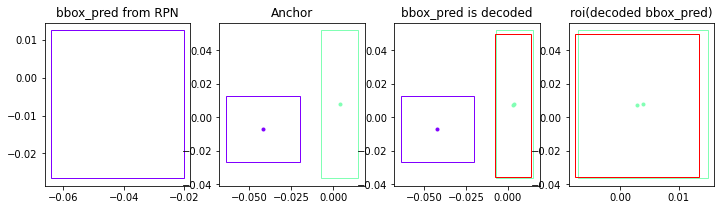

In [12]:
###########################################
### Visualize: Decoding in RPN proposal ###
###########################################
from utils import visualize_roi_process
for i in range(len(bbox_preds)):
    bbox_pred = bbox_preds[i]
    roi = rpn._decode(bbox_pred, center_anchors)
    break
visualize_roi_process(bbox_pred, center_anchors, roi)
del bbox_pred

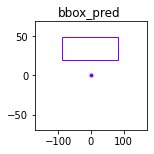

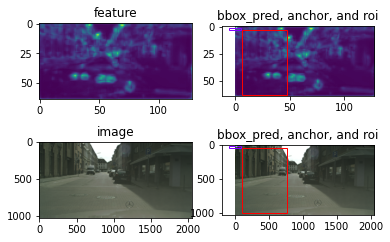

In [14]:
#######################
### Visualize: RoIs ###
#######################
from utils import visualize_bbox_xy, get_color_array

vis_ids = 5
COLOR_ARRAY = get_color_array(num_colors=3)

fig, ax = plt.subplots(1,1, figsize=(2,2))
scale = scale.to(config.device)
cxcy = (bbox_preds[0][vis_ids] * scale)[:2].cpu().detach().numpy()
wh = (bbox_preds[0][vis_ids] * scale)[2:].cpu().detach().numpy()
ax.axes.set_xlim([-(abs(cxcy[0])+wh[0]), abs(cxcy[0])+wh[0]])
ax.axes.set_ylim([-(abs(cxcy[1])+wh[1]), abs(cxcy[1])+wh[1]])
visualize_bbox_xy(bbox_preds[0][vis_ids] * scale, ax=ax, color_idx=0, num_colors=3)
ax.plot([0], [0], '.', color=COLOR_ARRAY[0])
fig.suptitle('bbox_pred')
plt.show(fig)

fig, axes = plt.subplots(2,2)

# axes[0,0]
visualize_feature_summary(features[0], fig=fig, ax=axes[0,0])
axes[0,0].axes.set_title('feature')

# axes[0,1]
visualize_feature_summary(features[0], fig=fig, ax=axes[0,1])

feat_width, feat_height = features.shape[-1], features.shape[-2]
scale = torch.tensor([feat_width, feat_height, feat_width, feat_height]).to(config.device)
visualize_bbox_xy(bbox_preds[0][vis_ids] * scale, ax=axes[0,1], color_idx=0, num_colors=3)

axes[0,1].plot([(center_anchors[vis_ids].squeeze(0)*scale)[0]], 
               [(center_anchors[vis_ids].squeeze(0)*scale)[1]], '.', color=COLOR_ARRAY[1], markersize=1)

visualize_bbox_xy(rois[0][vis_ids] * scale, ax=axes[0,1], color_idx=2, num_colors=3)
axes[0,1].axes.set_title('bbox_pred, anchor, and roi')

# axes[1,0]
axes[1,0].imshow(image.permute(1,2,0).cpu().detach().numpy())
axes[1,0].axes.set_title('image')

# axes[1,1]
axes[1,1].imshow(image.permute(1,2,0).cpu().detach().numpy())

image_width, image_height = image.shape[-1], image.shape[-2]
scale = torch.tensor([image_width, image_height, image_width, image_height]).to(config.device)
visualize_bbox_xy(bbox_preds[0][vis_ids] * scale, ax=axes[1,1], color_idx=0, num_colors=3)

COLOR_ARRAY = get_color_array(num_colors=3)
axes[1,1].plot([(center_anchors[vis_ids].squeeze(0)*scale)[0]], 
               [(center_anchors[vis_ids].squeeze(0)*scale)[1]], '.', color=COLOR_ARRAY[1], markersize=1)

visualize_bbox_xy(rois[0][vis_ids] * scale, ax=axes[1,1], color_idx=2, num_colors=3)
axes[1,1].axes.set_title('bbox_pred, anchor, and roi')

plt.show(fig)

# RoI



In [102]:
###############
### Setting ###
###############
config['model'].update({
    'roi': {
        'sampler': {
            'pos_iou_thr': 0.5,
            'neg_iou_thr': 0.5,
            'num_total': 128,
            'num_pos': 32,
        },
        'bbox_head': {
            'num_channels': 512, # This should be equal to backbone features' channel
            'num_classes': 8,    # This should be equal to dataset's class
        },
        'out_size': (7,7),
    },
})

###################
### RoI Network ###
###################
roi_network = build_roi(config.model.roi).to(config.device)

# Prerequisite 1. Data
gt_bboxes = dataset[0]['bboxes'].unsqueeze(0).to(config.device)
gt_labels = dataset[0]['labels'].unsqueeze(0).to(config.device)
images = dataset[0]['image'].unsqueeze(0).to(config.device)

# Prerequisite 1. Feature
backbone = build_backbone(config.model.backbone).to(config.device)
features = backbone(images)

# Prerequisite 2. Rois
rpn = build_rpn(config.model.rpn).to(config.device)
rois, cls_scores, bbox_preds = rpn(features)

# Forward
cls_scores, bbox_preds = roi_network(gt_bboxes, gt_labels, rois, features)
print(f"cls_scores: {cls_scores.shape}")
print(f"bbox_preds: {bbox_preds.shape}")

cls_scores: torch.Size([1, 128, 8])
bbox_preds: torch.Size([1, 128, 32])


**Sample**

Samples positive and negative

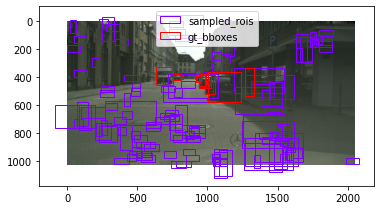

In [84]:
from model.roi import build_roi

###################
### roi_network ###
###################
roi_network = build_roi(config.model.roi).to(config.device)

gt_bboxes = dataset[0]['bboxes'].to(config.device).unsqueeze(0)
gt_labels = dataset[0]['labels'].to(config.device).unsqueeze(0)
rois, cls_scores, bbox_preds = rpn.to(config.device)(features)

##############
### Sample ###
##############
sampled_result = roi_network.sample(gt_bboxes, gt_labels, rois)
target_labels = sampled_result['labels']    # (B, num_samples), where num_samples=num_pos+num_neg
target_bboxes = sampled_result['bboxes']    # (B, num_samples, 4)
sampled_rois = sampled_result['rois']   

##################################
### Visualize: Sampled results ###
##################################
from utils import visualize_bboxes_cxcy
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1,1)
COLOR_ARRAY = get_color_array(num_colors=2)

# Image
ax.imshow(image.permute(1,2,0).cpu().detach().numpy())

# Sampled rois
image_width, image_height = image.shape[-1], image.shape[-2]
scale = torch.tensor([image_width, image_height, image_width, image_height]).to(config.device)
visualize_bboxes_cxcy(sampled_rois[0] * scale, ax=ax, color=COLOR_ARRAY[0])

# Ground-truth bounding boxes
visualize_bboxes_cxcy(gt_bboxes[0], ax=ax, color=COLOR_ARRAY[1])

# Legend
roi_legend = Rectangle((0,0), 0, 0, linewidth=1, edgecolor=COLOR_ARRAY[0], facecolor='none', label='sampled_rois')
gt_legend = Rectangle((0,0), 0, 0, linewidth=1, edgecolor=COLOR_ARRAY[1], facecolor='none', label='gt_bboxes')
ax.legend(handles=[roi_legend, gt_legend])


**BBoxRoIExtractor**

Extracts Region of Interest(RoI) from `features` with `out_size` using `torchvision.RoIPool`


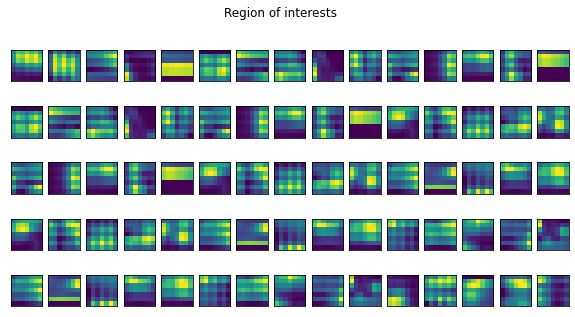

In [90]:
from model.roi import BBoxRoIExtractor

########################
### BBoxRoIExtractor ###
########################
bbox_roi_extractor = BBoxRoIExtractor(out_size=config.model.roi.out_size)

###############
### Forward ###
###############
bbox_feat_list = bbox_roi_extractor(features, sampled_rois)
bbox_feats = torch.stack(bbox_feat_list, dim=0)

######################################
### Visualize: Region of interests ###
######################################
num_rows, num_cols = 5, 15
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,5))
for row in range(num_rows):
    for col in range(num_cols):
        visualize_feature_summary(bbox_feats[0][num_rows*row+col], fig=fig, ax=axes[row, col])
        axes[row, col].axes.set_xticks([])
        axes[row, col].axes.set_yticks([])
fig.suptitle('Region of interests')
plt.show(fig)

**BBoxHead**

Get `cls_scores` and `bbox_preds` from `bbox_feats`

In [98]:
################
### BBoxHead ###
################
cls_scores, bbox_preds = roi_network.bbox_head(bbox_feats)

###############################
### Print: BBoxHead process ###
###############################
print(f"*** BBoxHead ***")
print(f"Input: ")
print(f"  > bbox_feats: {bbox_feats.shape}")
print(f"Process & Output: ")
batch_size, num_rois = bbox_feats.shape[0], bbox_feats.shape[1]
bbox_feats = bbox_feats.reshape(batch_size, num_rois, -1)
cls_feats = roi_network.bbox_head.classifier(bbox_feats)
print(f"  1. classifier: {roi_network.bbox_head.classifier}")
print(f"    > cls_feats: {cls_feats.shape}")
print(f"  2. fc_cls: {roi_network.bbox_head.fc_cls}")
print(f"    > cls_scores: {cls_scores.shape}")
print(f"  3. fc_reg: {roi_network.bbox_head.fc_reg}")
print(f"    > bbox_preds: {bbox_preds.shape}")

*** BBoxHead ***
Input: 
  > bbox_feats: torch.Size([1, 128, 25088])
Process & Output: 
  1. classifier: Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=4096, out_features=4096, bias=True)
  (3): ReLU(inplace=True)
)
    > cls_feats: torch.Size([1, 128, 4096])
  2. fc_cls: Linear(in_features=4096, out_features=8, bias=True)
    > cls_scores: torch.Size([1, 128, 8])
  3. fc_reg: Linear(in_features=4096, out_features=32, bias=True)
    > bbox_preds: torch.Size([1, 128, 32])
